In [1]:
# Código do TCC - DSA222 - MBA em Data Science e Analytics - EaD 2º Sem /2022
# Por Marcos Roberto Rodrigues em março de 2024
# Objetivo é executar Rede Neural GRU na Predição da Produtvidade de cana-se-açucar no Brasil

In [2]:
import math
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import tensorflow

In [3]:
# criando dataframe...
# fonte: https://www.conab.gov.br/info-agro/safras/serie-historica-das-safras/itemlist/category/891-cana-de-acucar-agricola"
# na planilha tem 3 pastas: Área, Produtividade e Produção
# Na linha 6 tem a safra, na coluna A a localização, em estado, sumarizando por região e total
# Vamos trabalhar com Produtividade que é o resultado da Produção dividido por Área

pd.options.mode.chained_assignment = None

file = '/Users/User/Documents/Marcos/CanaSerieHistZ.xls'
prodcana = pd.read_excel(file, sheet_name = 2)

df = pd.DataFrame(prodcana)
df.drop([0,1,2,3,40,41,42], inplace = True)
df.columns = df.iloc[0]
df.index = df['REGIÃO/UF']
df.drop(['REGIÃO/UF'], axis = 1, inplace = True)
df.drop(['REGIÃO/UF'], inplace = True)

df_invertido = df.transpose()



In [4]:
# Dados históricos das Embrapa foram adicionado...  
# https://ainfo.cnptia.embrapa.br/digital/bitstream/item/214997/1/Cap19-EvolucaoProducaoCanadeAcucar.pdf
# Extraido de um grafico

dados_numpy = np.array([61479, 61955, 64597, 63289, 67233, 66614, 66755, 68884, 69247, 68148, 67878, 69443, 71443, 73731, 73726])
ano_numpy = np.array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004])

TSAnterior = pd.Series(dados_numpy,index=[ano_numpy] )

TSAtual = df.loc['BRASIL']
TSAtual.index = TSAtual.index.str[0:4]
TSAtual = TSAtual.astype('int32')
TSTotal = pd.concat([TSAnterior, TSAtual])

linha_array = TSTotal.to_numpy().reshape(-1, 1)

dfSafra = pd.DataFrame(list(TSTotal.items()), columns=['Ano', 'Valor'])
dfSafra['Ano'] = dfSafra['Ano'].apply(lambda x: str(x).strip('(),'))
dfSafra = dfSafra.set_index('Ano')

# Neste final temos linha_array com arrray com dados, e dfSafra, com Ano como indice e dados, completo
 

In [5]:

tamanho_dados_treinamento = int(len(linha_array) * 0.8)
tamanho_dados_teste = len(linha_array) - tamanho_dados_treinamento


In [6]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

from sklearn.preprocessing import MinMaxScaler 

#Outra definição e a Normalização, que  é uma técnica que visa colocar os dados
#em uma escala comum, sem distorcer as diferenças nos intervalos de valores.

escalador = MinMaxScaler(feature_range=(0, 1))

# Nesta versão fazemos escalar o todo linha_array.
safra = escalador.fit_transform(linha_array)


In [7]:
# Preparar os dados para entrada na RNN, para GRU

def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 27

X, y = prepare_data(safra, time_steps)


In [9]:
# Reshape dos dados para o formato [samples, time steps, features]

X = X.reshape(X.shape[0], X.shape[1], 1)

# Construir o modelo RNN GRU
model = Sequential()
model.add(GRU(units=50, input_shape=(time_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X, y, epochs=50, batch_size=32)

# Fazer previsões
predictions = model.predict(X)

# Desnormalizar as previsões
predictions = escalador.inverse_transform(predictions)
safra = escalador.inverse_transform(safra)


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6546
Epoch 2/50
1/1 [==============================] - 0s 12ms/step - loss: 0.5953
Epoch 3/50
1/1 [==============================] - 0s 11ms/step - loss: 0.5393
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 0.4866
Epoch 5/50
1/1 [==============================] - 0s 12ms/step - loss: 0.4370
Epoch 6/50
1/1 [==============================] - 0s 10ms/step - loss: 0.3903
Epoch 7/50
1/1 [==============================] - 0s 11ms/step - loss: 0.3464
Epoch 8/50
1/1 [==============================] - 0s 12ms/step - loss: 0.3052
Epoch 9/50
1/1 [==============================] - 0s 13ms/step - loss: 0.2666
Epoch 10/50
1/1 [==============================] - 0s 11ms/step - loss: 0.2305
Epoch 11/50
1/1 [==============================] - 0s 12ms/step - loss: 0.1971
Epoch 12/50
1/1 [==============================] - 0s 12ms/step - loss: 0.1662
Epoch 13/50
1/1 [==============================] - 0s 11ms/step

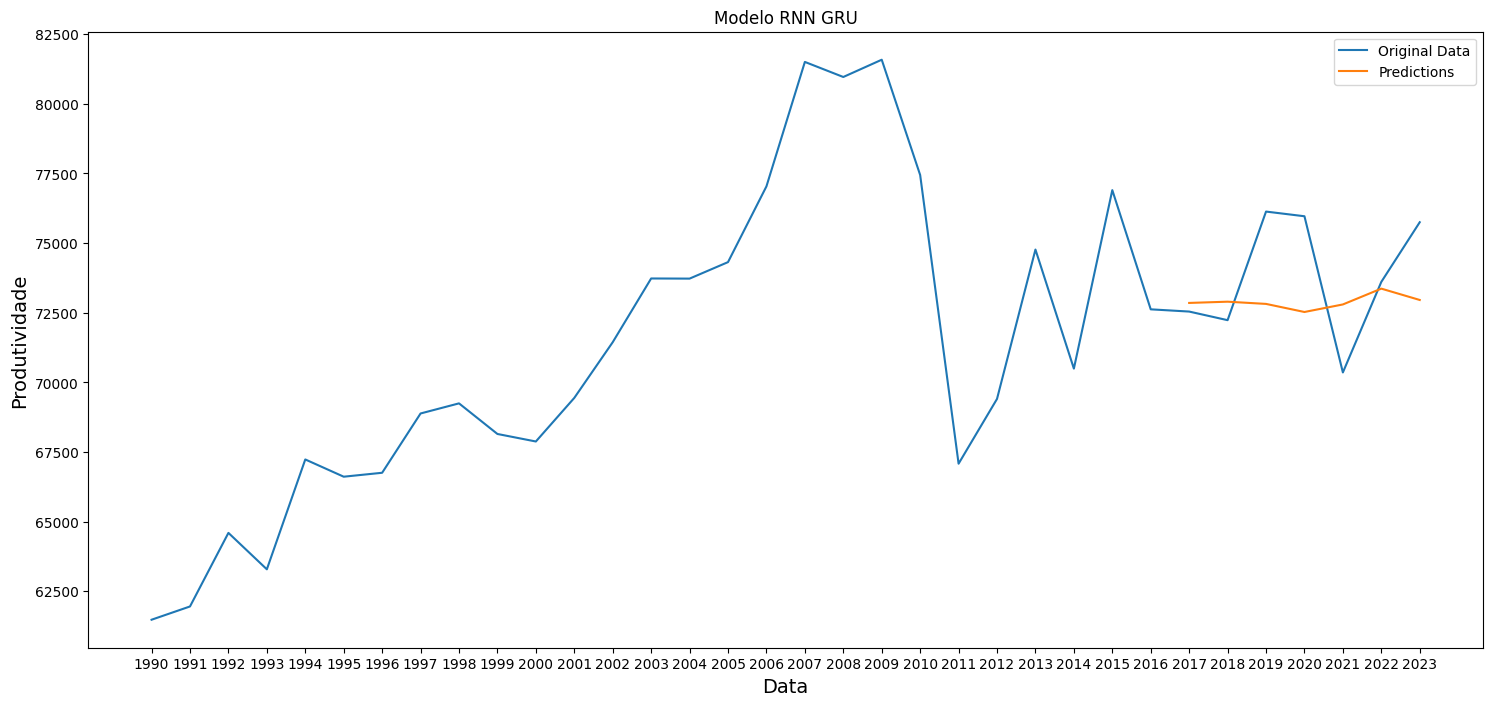

In [10]:
# Plotar os dados originais e as previsões
import matplotlib.pyplot as plt
plt.figure(figsize =(18, 8))
plt.title('Modelo RNN GRU')
plt.xlabel('Data', fontsize = 14)
plt.ylabel("Produtividade", fontsize = 14)
plt.plot(dfSafra, label='Original Data')
plt.plot(np.arange(time_steps, len(safra)), predictions, label='Predictions')
plt.legend()
plt.show()

In [15]:
rmse = np.sqrt(np.mean(predictions - y) ** 2)
rmse

72887.93525286962